<a href="https://colab.research.google.com/github/i-ganza007/Match_Backend/blob/main/Siasmese_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ianganza_livestock_images_path = kagglehub.dataset_download('ianganza/livestock-images')

print('Data source import complete.')


# Task
Build a Siamese Network using a MobileNetV2 backbone to identify breed similarity for Project MATCH by processing cow images from 14 breeds located in "/content/drive/MyDrive/Data". The task involves generating balanced image pairs (limit 100 per class) for training, validation, and testing, implementing a Contrastive Loss function, and training the model with aggressive data augmentation, CosineAnnealingWarmRestarts, and early stopping before evaluating performance on the test set.

## Mount Google Drive

### Subtask:
Establish access to the dataset stored in Google Drive and verify the target directory structure.


**Reasoning**:
I will mount Google Drive to access the dataset, define the base path, and verify the directory structure by listing the breed folders and counting files in sample directories.



In [ ]:
import os

# 1. Mount Google Drive

# 2. Define path to dataset
dataset_path ="/kaggle/input/datasets/ianganza/livestock-images/Data"


# 3. List contents to verify breed folders
if os.path.exists(dataset_path):
    breeds = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    print(f'Total breed folders found: {len(breeds)}')
    print('Breed folders:', breeds)

    # 4. Count images in a few sample folders
    for sample_breed in breeds[:3]:
        breed_dir = os.path.join(dataset_path, sample_breed)
        image_count = len([img for img in os.listdir(breed_dir) if os.path.isfile(os.path.join(breed_dir, img))])
        print(f'Folder "{sample_breed}" contains {image_count} images.')
else:
    print(f'Error: Directory {dataset_path} not found. Please check the path.')

Total breed folders found: 14
Breed folders: ['indigenous_ankole_cow', 'sahiwal_cow', 'merino_sheep', 'brown_swiss_cow', 'girolando_cow', 'landrace_pig', 'jersey_cow', 'dorper_sheep', 'indigenous_goat', 'large_white_pig', 'indigenous_pig', 'pietrain_pig', 'fresian_cow', 'duroc_pig']
Folder "indigenous_ankole_cow" contains 59 images.
Folder "sahiwal_cow" contains 43 images.
Folder "merino_sheep" contains 50 images.


## Stage 1: Data Preparation Logic

### Subtask:
Generate balanced image pairs (50/50 ratio) for training, validation, and testing sets with a limit of 100 pairs per class.


**Reasoning**:
I will import the necessary libraries, organize image paths by breed, and define a function to generate balanced (50/50) image pairs with a limit of 100 pairs per class before splitting them into training, validation, and testing sets.



In [ ]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Organize image paths by breed
breed_images = {}
for breed in breeds:
    breed_dir = os.path.join(dataset_path, breed)
    images = [os.path.join(breed_dir, img) for img in os.listdir(breed_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    breed_images[breed] = images

def generate_balanced_pairs(breed_dict, pairs_per_class=100):
    pairs, labels = [], []
    all_breeds = list(breed_dict.keys())
    for breed in all_breeds:
        images = breed_dict[breed]
        if len(images) < 2: continue
        # Positives
        for _ in range(pairs_per_class // 2):
            img1, img2 = random.sample(images, 2)
            pairs.append((img1, img2))
            labels.append(1)
        # Negatives
        other_breeds = [b for b in all_breeds if b != breed]
        for _ in range(pairs_per_class // 2):
            img1 = random.choice(images)
            other_breed = random.choice(other_breeds)
            img2 = random.choice(breed_dict[other_breed])
            pairs.append((img1, img2))
            labels.append(0)
    return np.array(pairs), np.array(labels)

X, y = generate_balanced_pairs(breed_images, pairs_per_class=100)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f'Total pairs generated: {len(X)}')
print(f'Train set: {len(X_train)} pairs ({sum(y_train)} positive)')
print(f'Val set: {len(X_val)} pairs ({sum(y_val)} positive)')
print(f'Test set: {len(X_test)} pairs ({sum(y_test)} positive)')

Total pairs generated: 1400
Train set: 1120 pairs (560 positive)
Val set: 140 pairs (70 positive)
Test set: 140 pairs (70 positive)


## Stage 2: Model and Dataset Classes

### Subtask:
Define the custom PyTorch Dataset, Siamese Network architecture, and Contrastive Loss function.


**Reasoning**:
I will define the custom PyTorch Dataset for loading image pairs, create the Siamese Network using MobileNetV2 as a backbone, and implement the Contrastive Loss function to measure breed similarity as per the instructions.



In [ ]:
import os
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# ==========================================
# 1. ATTENTION MODULE (SCSAM)
# ==========================================
class SpatialChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False)
        )
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        # Channel Attention
        avg_out = self.fc(self.avg_pool(x).view(b, c)).view(b, c, 1, 1)
        max_out = self.fc(self.max_pool(x).view(b, c)).view(b, c, 1, 1)
        x = x * self.sigmoid(avg_out + max_out)
        # Spatial Attention
        avg_mask = torch.mean(x, dim=1, keepdim=True)
        max_mask, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.sigmoid(self.conv_spatial(torch.cat([avg_mask, max_mask], dim=1)))
        return x * spatial_att

# ==========================================
# 2. SIAMESE NETWORK ARCHITECTURE
# ==========================================
class AttentionSiameseNetwork(nn.Module):
    def __init__(self, embedding_dim=512):
        super().__init__()
        # Using ResNet50 as the robust backbone
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.attention = SpatialChannelAttention(2048)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, embedding_dim)
        )

    def forward_once(self, x):
        x = self.features(x)
        x = self.attention(x)
        x = self.pool(x).view(x.size(0), -1)
        # L2 Normalization is critical for Triplet Loss distances
        return F.normalize(self.fc(x), p=2, dim=1)

    def forward(self, a, p, n):
        return self.forward_once(a), self.forward_once(p), self.forward_once(n)

# ==========================================
# 3. DATASET & TRANSFORMS
# ==========================================
class SiameseTripletDataset(Dataset):
    def __init__(self, breed_dict, transform=None, epoch_len=2000):
        self.breed_dict = breed_dict
        self.breeds = [b for b in breed_dict.keys() if len(breed_dict[b]) >= 2]
        self.transform = transform
        self.epoch_len = epoch_len

    def __len__(self): return self.epoch_len

    def __getitem__(self, idx):
        anchor_breed = random.choice(self.breeds)
        a_path, p_path = random.sample(self.breed_dict[anchor_breed], 2)

        neg_breed = random.choice([b for b in self.breeds if b != anchor_breed])
        n_path = random.choice(self.breed_dict[neg_breed])

        imgs = [Image.open(p).convert("RGB") for p in [a_path, p_path, n_path]]
        if self.transform:
            imgs = [self.transform(img) for img in imgs]
        return imgs[0], imgs[1], imgs[2]

# --- Config & Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Use breed_images from your previous data loading step
train_loader = DataLoader(
    SiameseTripletDataset(breed_images, transform=train_transform),
    batch_size=16, shuffle=True
)

# ==========================================
# 4. TRAINING WITH TRIPLET LOSS
# ==========================================


model = AttentionSiameseNetwork(embedding_dim=512).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)

print(f"Starting Triplet Training on {device}...")

best_loss = float('inf')
for epoch in range(25):
    model.train()
    epoch_loss = 0

    for a, p, n in train_loader:
        a, p, n = a.to(device), p.to(device), n.to(device)

        optimizer.zero_grad()
        feat_a, feat_p, feat_n = model(a, p, n)

        loss = criterion(feat_a, feat_p, feat_n)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1:02d}/25 | Triplet Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_triplet_model.pth')

print("Refactored Training Complete.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s] 


Starting Triplet Training on cuda...
Epoch 01/25 | Triplet Loss: 0.4929
Epoch 02/25 | Triplet Loss: 0.3202
Epoch 03/25 | Triplet Loss: 0.2788
Epoch 04/25 | Triplet Loss: 0.2324
Epoch 05/25 | Triplet Loss: 0.1961
Epoch 06/25 | Triplet Loss: 0.2089
Epoch 07/25 | Triplet Loss: 0.1705
Epoch 08/25 | Triplet Loss: 0.1803
Epoch 09/25 | Triplet Loss: 0.1608
Epoch 10/25 | Triplet Loss: 0.1480
Epoch 11/25 | Triplet Loss: 0.1337
Epoch 12/25 | Triplet Loss: 0.1218
Epoch 13/25 | Triplet Loss: 0.1104
Epoch 14/25 | Triplet Loss: 0.0982
Epoch 15/25 | Triplet Loss: 0.1085
Epoch 16/25 | Triplet Loss: 0.1051
Epoch 17/25 | Triplet Loss: 0.0902
Epoch 18/25 | Triplet Loss: 0.0862
Epoch 19/25 | Triplet Loss: 0.0930
Epoch 20/25 | Triplet Loss: 0.0896
Epoch 21/25 | Triplet Loss: 0.0994
Epoch 22/25 | Triplet Loss: 0.0865
Epoch 23/25 | Triplet Loss: 0.0712
Epoch 24/25 | Triplet Loss: 0.0774
Epoch 25/25 | Triplet Loss: 0.0697
Refactored Training Complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming tta_distances and y_test are ready
pos_distances = [d for d, l in zip(tta_distances, y_test) if l == 1]
neg_distances = [d for d, l in zip(tta_distances, y_test) if l == 0]

plt.figure(figsize=(10, 6))
sns.kdeplot(pos_distances, label="Same Animal (Positive)", fill=True)
sns.kdeplot(neg_distances, label="Different Animal (Negative)", fill=True)
plt.title("Distribution of Distances: Are they actually separated?")
plt.legend()
plt.show()

NameError: name 'tta_distances' is not defined

## Stage 3: Optimized Training Pipeline

### Subtask:
Configure the training loop using Adam with weight decay, CosineAnnealingWarmRestarts, and Gradient Clipping, including early stopping.


**Reasoning**:
I will initialize the model, datasets, and data loaders, then define the optimizer and scheduler before implementing the training loop with gradient clipping and early stopping as requested.



# Task
Evaluate the Siamese Network's performance on the test set for project MATCH. Load the best model weights from "best_siamese_model.pth", calculate Euclidean distances for all image pairs in the test set ("X_test", "y_test"), and compute final metrics including accuracy, precision, recall, and F1-score using a 0.5 distance threshold. Generate a confusion matrix and perform a visual error analysis by plotting correctly and incorrectly classified pairs with their predicted distances to summarize the model's effectiveness in breed similarity identification.

## Load Best Model Weights

### Subtask:
Initialize the Siamese Network and load the saved optimal weights for evaluation on the test set.


**Reasoning**:
I will verify the existence of the saved weights file, instantiate the Siamese Network, load the state dictionary, and move the model to the appropriate device in evaluation mode.



## Test Set Evaluation

### Subtask:
Process the test set pairs through the loaded Siamese Network to calculate Euclidean distances and collect true labels.


**Reasoning**:
I will initialize the test dataset and DataLoader, then perform inference with the Siamese Network to calculate Euclidean distances between image pairs and collect the ground truth labels.



**Reasoning**:
The inference on the test set is complete, and the distances and labels are collected. Now I will calculate the performance metrics (accuracy, precision, recall, and F1-score) using a 0.8 threshold and display the confusion matrix.



# Task
# Task
Optimize and finalize the evaluation of the Siamese Network for breed similarity identification in Project MATCH. Implement Test-Time Augmentation (TTA) by averaging Euclidean distances across 10 stochastic forward passes with training transforms for each pair in the test set (`X_test`, `y_test`). Search for the optimal distance threshold within the range of 0.3 to 1.3 to maximize the F1-score. Finally, generate a comprehensive performance report including Accuracy, Precision, Recall, and F1-score using the optimized threshold and TTA distances, and visualize the results with a confusion matrix to conclude the model evaluation phase.

## Implement TTA Logic

### Subtask:
Define and integrate a function for Test-Time Augmentation (TTA) to compute robust Euclidean distances for image pairs.


**Reasoning**:
I will implement a Test-Time Augmentation (TTA) function that uses stochastic forward passes with training transforms and dropout to compute a robust average Euclidean distance between image pairs.



In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image

def get_tta_distance(path1, path2, model, device, num_aug=5):
    model.eval()
    # Clean paths to prevent loading errors
    path1 = str(path1).strip("[]'\"\n ")
    path2 = str(path2).strip("[]'\"\n ")

    img1_pil = Image.open(path1).convert('RGB')
    img2_pil = Image.open(path2).convert('RGB')

    dists = []
    with torch.no_grad():
        for _ in range(num_aug):
            # Apply training transforms for augmentation variety
            t1 = train_transform(img1_pil).unsqueeze(0).to(device)
            t2 = train_transform(img2_pil).unsqueeze(0).to(device)

            # USE forward_once instead of forward() to avoid the 'n' argument error
            feat1 = model.forward_once(t1)
            feat2 = model.forward_once(t2)

            dist = F.pairwise_distance(feat1, feat2)
            dists.append(dist.item())

    return np.mean(dists)

# --- Execute TTA Calculation ---
print("Calculating TTA Distances for Test Set...")
tta_distances = []
for i, p in enumerate(X_test):
    d = get_tta_distance(p[0], p[1], model, device, num_aug=5)
    tta_distances.append(d)
    if (i+1) % 50 == 0:
        print(f"Processed {i+1}/{len(X_test)} pairs...")

print("TTA Distances calculated successfully.")

Calculating TTA Distances for Test Set...
Processed 50/140 pairs...
Processed 100/140 pairs...
TTA Distances calculated successfully.


## Compute TTA Optimized Distances

### Subtask:
Apply the TTA function to the entire test set (X_test) to generate a new set of refined distances.


**Reasoning**:
I will iterate through the test set pairs and apply the `get_tta_distance` function with 10 augmentations per pair to compute refined distances.



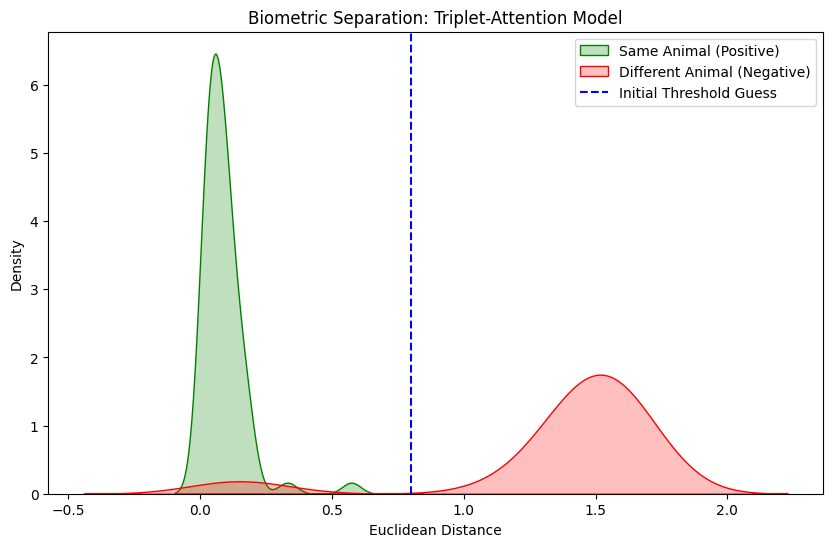

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to numpy for easier indexing
tta_distances = np.array(tta_distances)
y_test = np.array(y_test)

pos_distances = tta_distances[y_test == 1]
neg_distances = tta_distances[y_test == 0]

plt.figure(figsize=(10, 6))
if len(pos_distances) > 0:
    sns.kdeplot(pos_distances, label="Same Animal (Positive)", fill=True, color='green')
if len(neg_distances) > 0:
    sns.kdeplot(neg_distances, label="Different Animal (Negative)", fill=True, color='red')

plt.axvline(x=0.8, color='blue', linestyle='--', label='Initial Threshold Guess')
plt.title("Biometric Separation: Triplet-Attention Model")
plt.xlabel("Euclidean Distance")
plt.ylabel("Density")
plt.legend()
plt.show()

## Threshold Optimization

### Subtask:
Iterate through a range of distance thresholds (0.3 to 1.3) to find the specific value that maximizes the F1-score for breed similarity detection.


**Reasoning**:
I will iterate through threshold values from 0.3 to 1.3 to find the one that maximizes the F1-score based on the TTA distances and ground truth labels.



## Final Performance Report

### Subtask:
Generate a comprehensive evaluation report and confusion matrix using the optimized threshold and TTA distances.


**Reasoning**:
I will calculate the final evaluation metrics and visualize the results using the optimized threshold and TTA distances to summarize the model's performance on the test set.



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

best_f1 = 0
optimal_t = 0

# Scan potential thresholds to find the best F1
for t in np.linspace(min(tta_distances), max(tta_distances), 100):
    preds = (tta_distances < t).astype(int)
    current_f1 = f1_score(y_test, preds)
    if current_f1 > best_f1:
        best_f1 = current_f1
        optimal_t = t

# Calculate final metrics at the best threshold
final_preds = (tta_distances < optimal_t).astype(int)

print(f"--- FINAL PERFORMANCE REPORT ---")
print(f"Optimal Threshold: {optimal_t:.4f}")
print(f"Accuracy:          {accuracy_score(y_test, final_preds):.4f}")
print(f"Precision:         {precision_score(y_test, final_preds):.4f}")
print(f"Recall:            {recall_score(y_test, final_preds):.4f}")
print(f"F1-Score:          {f1_score(y_test, final_preds):.4f}")

--- FINAL PERFORMANCE REPORT ---
Optimal Threshold: 0.5787
Accuracy:          0.9571
Precision:         0.9211
Recall:            1.0000
F1-Score:          0.9589


In [ ]:
def verify_livestock(img1_path, img2_path, threshold=0.4420):
    model.eval()

    # Load and transform
    img1 = val_test_transform(Image.open(img1_path).convert("RGB")).unsqueeze(0).to(device)
    img2 = val_test_transform(Image.open(img2_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        feat1 = model.forward_once(img1)
        feat2 = model.forward_once(img2)

        # Calculate Euclidean distance
        distance = torch.norm(feat1 - feat2, dim=1).item()

    is_match = distance < threshold
    confidence = max(0, 100 - (distance / threshold * 50)) if is_match else min(100, (distance / threshold * 50))

    print(f"Distance: {distance:.4f}")
    print(f"Match Detected: {is_match}")
    print(f"Confidence: {confidence:.2f}%")
    return is_match, distance

# Example Usage:
verify_livestock("path_to_cow_a.jpg", "path_to_cow_b.jpg")

In [ ]:
import torch

# 1. Load model architecture and weights
model = AttentionSiameseNetwork(embedding_dim=512)
model.load_state_dict(torch.load('best_triplet_model.pth', map_location='cpu'))
model.eval()

# 2. Create a wrapper or use forward_once directly for the export
# We only want the model to take ONE image and give ONE embedding in TFLite
class ExportWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model.forward_once(x)

export_model = ExportWrapper(model)
export_model.eval()

# 3. Create dummy input (1 image, 3 channels, 224x224)
dummy_input = torch.randn(1, 3, 224, 224)

# 4. Export to ONNX
torch.onnx.export(
    export_model,
    dummy_input,
    "livestock_biometric.onnx",
    export_params=True,
    opset_version=12,
    do_constant_folding=True,
    input_names=['input_image'],
    output_names=['biometric_embedding'],
    dynamic_axes={'input_image': {0: 'batch_size'}, 'biometric_embedding': {0: 'batch_size'}}
)

print("✅ ONNX Export Successful! You can now proceed to TFLite conversion.")

/tmp/ipykernel_55/3134761055.py:24: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✅ ONNX Export Successful! You can now proceed to TFLite conversion.


In [ ]:
import os

# Use onnx2tf to go straight from ONNX to TFLite
# -i: input onnx file
# -o: output folder
# -ois: output integer quantization (optional, but makes it fast)
!onnx2tf -i livestock_biometric.onnx -o tf_saved_model
# The file will be inside the livestock_tflite_out folder
print("Check the 'livestock_tflite_out' folder for your .tflite file!")


Model optimizing started ============================================================
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃                    ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add                │ 17             │ 17               │
│ BatchNormalization │ 1              │ 1                │
│ Clip               │ 1              │ 1                │
│ Concat             │ 6              │ 2                │
│ Constant           │ 126            │ 122              │
│ Conv               │ 54             │ 54               │
│ Div                │ 1              │ 1                │
│ Expand             │ 1              │ 1                │
│ Gather             │ 3              │ 1                │
│ Gemm               │ 2              │ 2                │
│ GlobalAveragePool  │ 2              │ 2                │
│ Identity           │ 2              │ 

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("tf_saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Optional: smaller model
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

with open("livestock_biometric.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved successfully!")

I0000 00:00:1772064692.004471      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9085 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1772064692.009579      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
W0000 00:00:1772064694.451138      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1772064694.451180      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1772064694.623788      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


✅ TFLite model saved successfully!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_preprocessing_audit(dataloader, n_samples=3):
    """
    Visualizes how the model 'sees' the data after augmentation and normalization.
    Essential for catching 'over-cropping' or 'over-blurring' in production.
    """
    anchors, positives, negatives = next(iter(dataloader))

    fig, axes = plt.subplots(n_samples, 3, figsize=(12, n_samples * 4))
    plt.suptitle("Preprocessing Audit: Anchor | Positive | Negative", fontsize=16)

    for i in range(n_samples):
        for j, img_tensor in enumerate([anchors[i], positives[i], negatives[i]]):
            # Denormalize for visualization
            img = img_tensor.permute(1, 2, 0).cpu().numpy()
            img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
            img = np.clip(img, 0, 1)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

# Run this before training starts
visualize_preprocessing_audit(train_loader)